In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

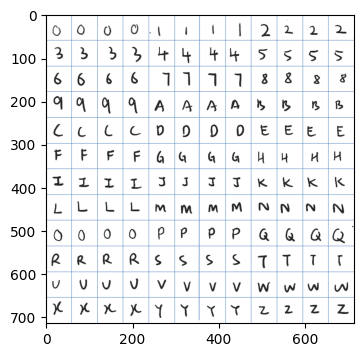

In [28]:
image_path = '/content/drive/My Drive/Dataset/St.png'
image = Image.open(image_path)

def show(img, figsize=(8, 4), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

show(image)

In [29]:
print(f'Image details')
print(f'Format {image.format}')
print(f'Size {image.size}')
print(f'Mode {image.mode}')

Image details
Format PNG
Size (714, 714)
Mode RGBA


The image is 1642x1639 pixels, contains 12x12 digits, each drawn in a square 136.58x136.58 pixels. Color mode is RGB, which is 3x8-bit pixels, true color.
Plan:
1. Change color mode to black-and-white, 256 shades
2. Cut square images 136.58 pixels each
3. Center images and crop to 28x28 pixels
4. Save output to numpy binary format

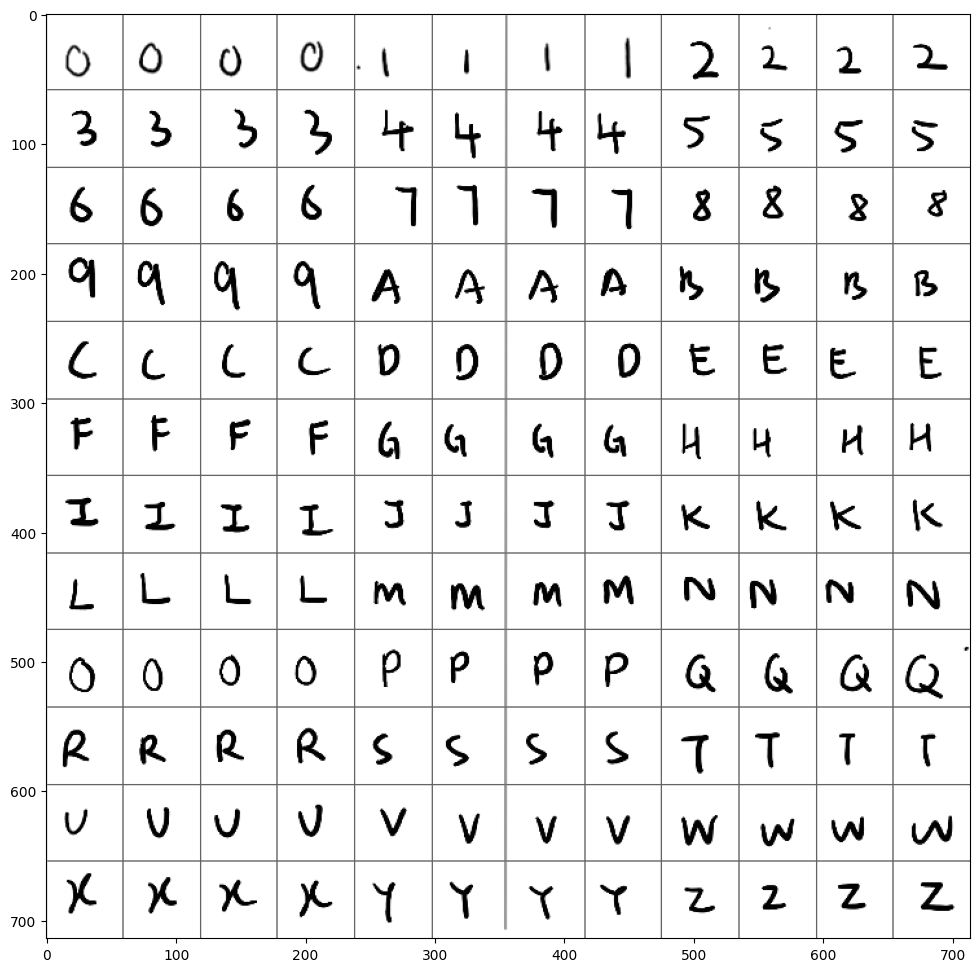

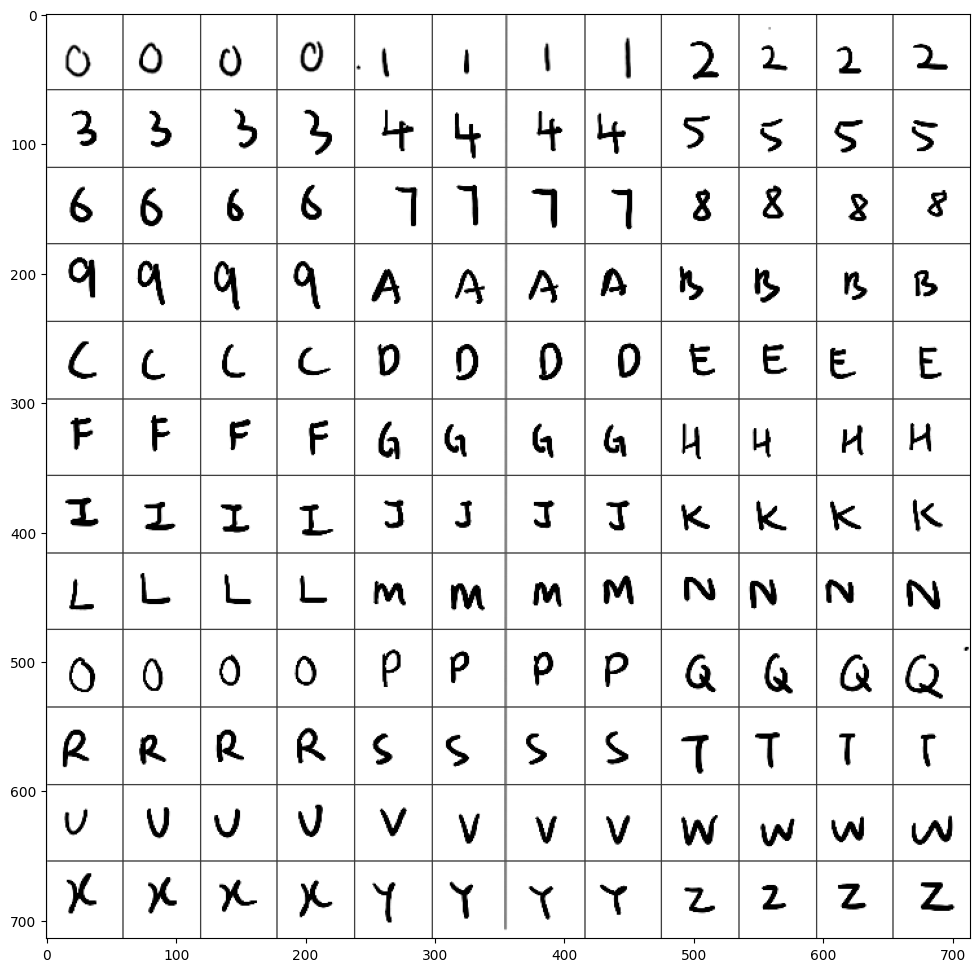

In [30]:
# Change color mode to black-and-white, 256 shades
from PIL import ImageEnhance

bw_image = image.convert(mode='L') #L is 8-bit black-and-white image mode
show(bw_image, figsize=(12, 12))
bw_image = ImageEnhance.Contrast(bw_image).enhance(1.5)
show(bw_image, figsize=(12, 12))

In [36]:
SIZE = 59.5
samples = []  # Array to store cut images
y = 0
digit = 0
while y < bw_image.height:
    cuts = []
    x = 0
    while x < bw_image.width:
        cut = bw_image.crop(box=(x, y, x + SIZE, y + SIZE))
        cuts.append(cut)
        x += SIZE
    samples.append(cuts)
    y += SIZE
    digit += 1

print(f'Cut {len(samples) * len(cuts)} images total.')

Cut 144 images total.


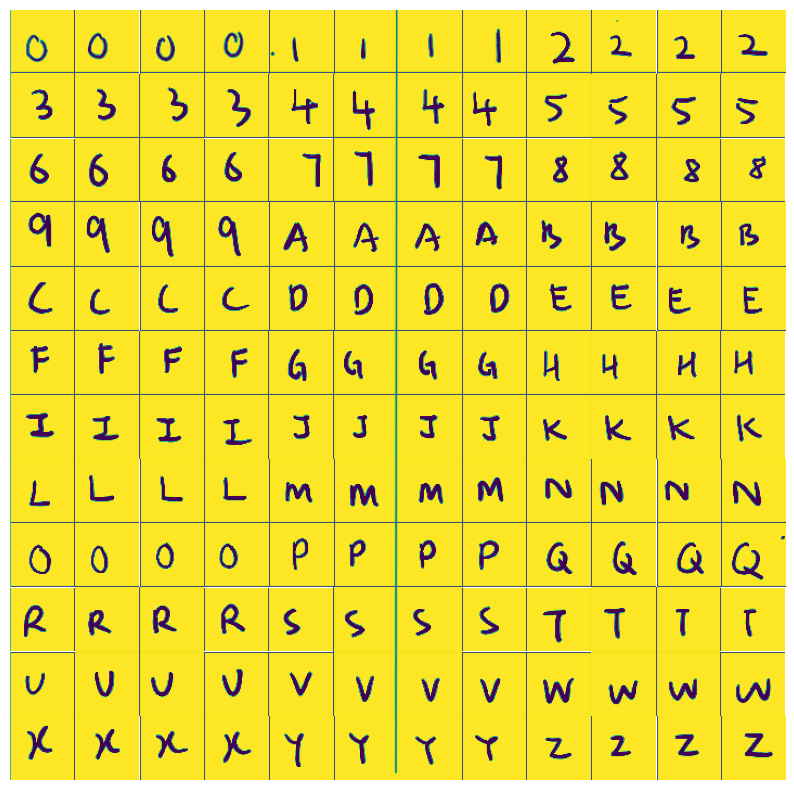

In [37]:
import matplotlib.pyplot as plt

# Set up the plot size and figure
fig, axes = plt.subplots(nrows=len(samples), ncols=len(samples[0]), figsize=(10, 10))

# Remove the gaps between images
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through all the rows and columns and plot each image
for i, row in enumerate(samples):
    for j, img in enumerate(row):
        ax = axes[i][j]
        ax.imshow(img)
        ax.axis('off')  # Hide axes

plt.show()


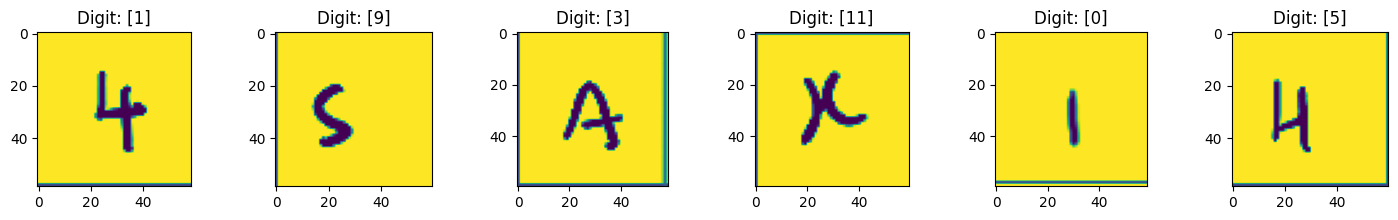

In [38]:
f = plt.figure(figsize=(18,2))
ax = f.subplots(1, 6)
for i, n in enumerate(np.random.randint(0, len(samples), size=6)):
    m = (np.random.randint(0, len(samples[n])))
    ax[i].imshow(samples[n][m])
    ax[i].set_title(f'Digit: [{n}]')
plt.show()

In [39]:
from PIL import ImageOps
import matplotlib.patches as patches
def resize_and_center(sample, new_size=28):
    inv_sample = ImageOps.invert(sample)
    bbox = inv_sample.getbbox()
    if bbox:
        crop = inv_sample.crop(bbox)
    else:
        crop = sample

    delta_w = new_size - crop.size[0]
    delta_h = new_size - crop.size[1]
    padding = (
        max(delta_w // 2, 0),
        max(delta_h // 2, 0),
        max(delta_w - (delta_w // 2), 0),
        max(delta_h - (delta_h // 2), 0)
    )

    padded_crop = ImageOps.expand(crop, padding)
    resized_crop = padded_crop.resize((new_size, new_size), Image.ANTIALIAS)
    return resized_crop

resized_samples = []
for row in samples:
    resized_samples.append([resize_and_center(sample) for sample in row])

<ipython-input-39-28ef2dd2a82e>:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_crop = padded_crop.resize((new_size, new_size), Image.ANTIALIAS)


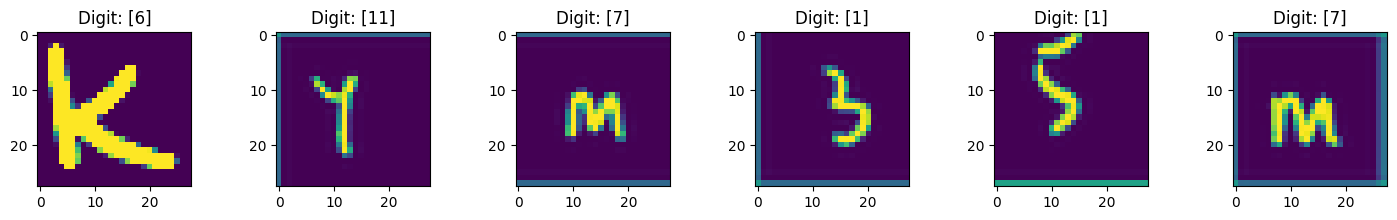

In [40]:
f = plt.figure(figsize=(18,2))
ax = f.subplots(1, 6)
for i, n in enumerate(np.random.randint(0, len(resized_samples), size=6)):
    m = (np.random.randint(0, len(resized_samples[n])))
    ax[i].imshow(resized_samples[n][m])
    ax[i].set_title(f'Digit: [{n}]')
plt.show()

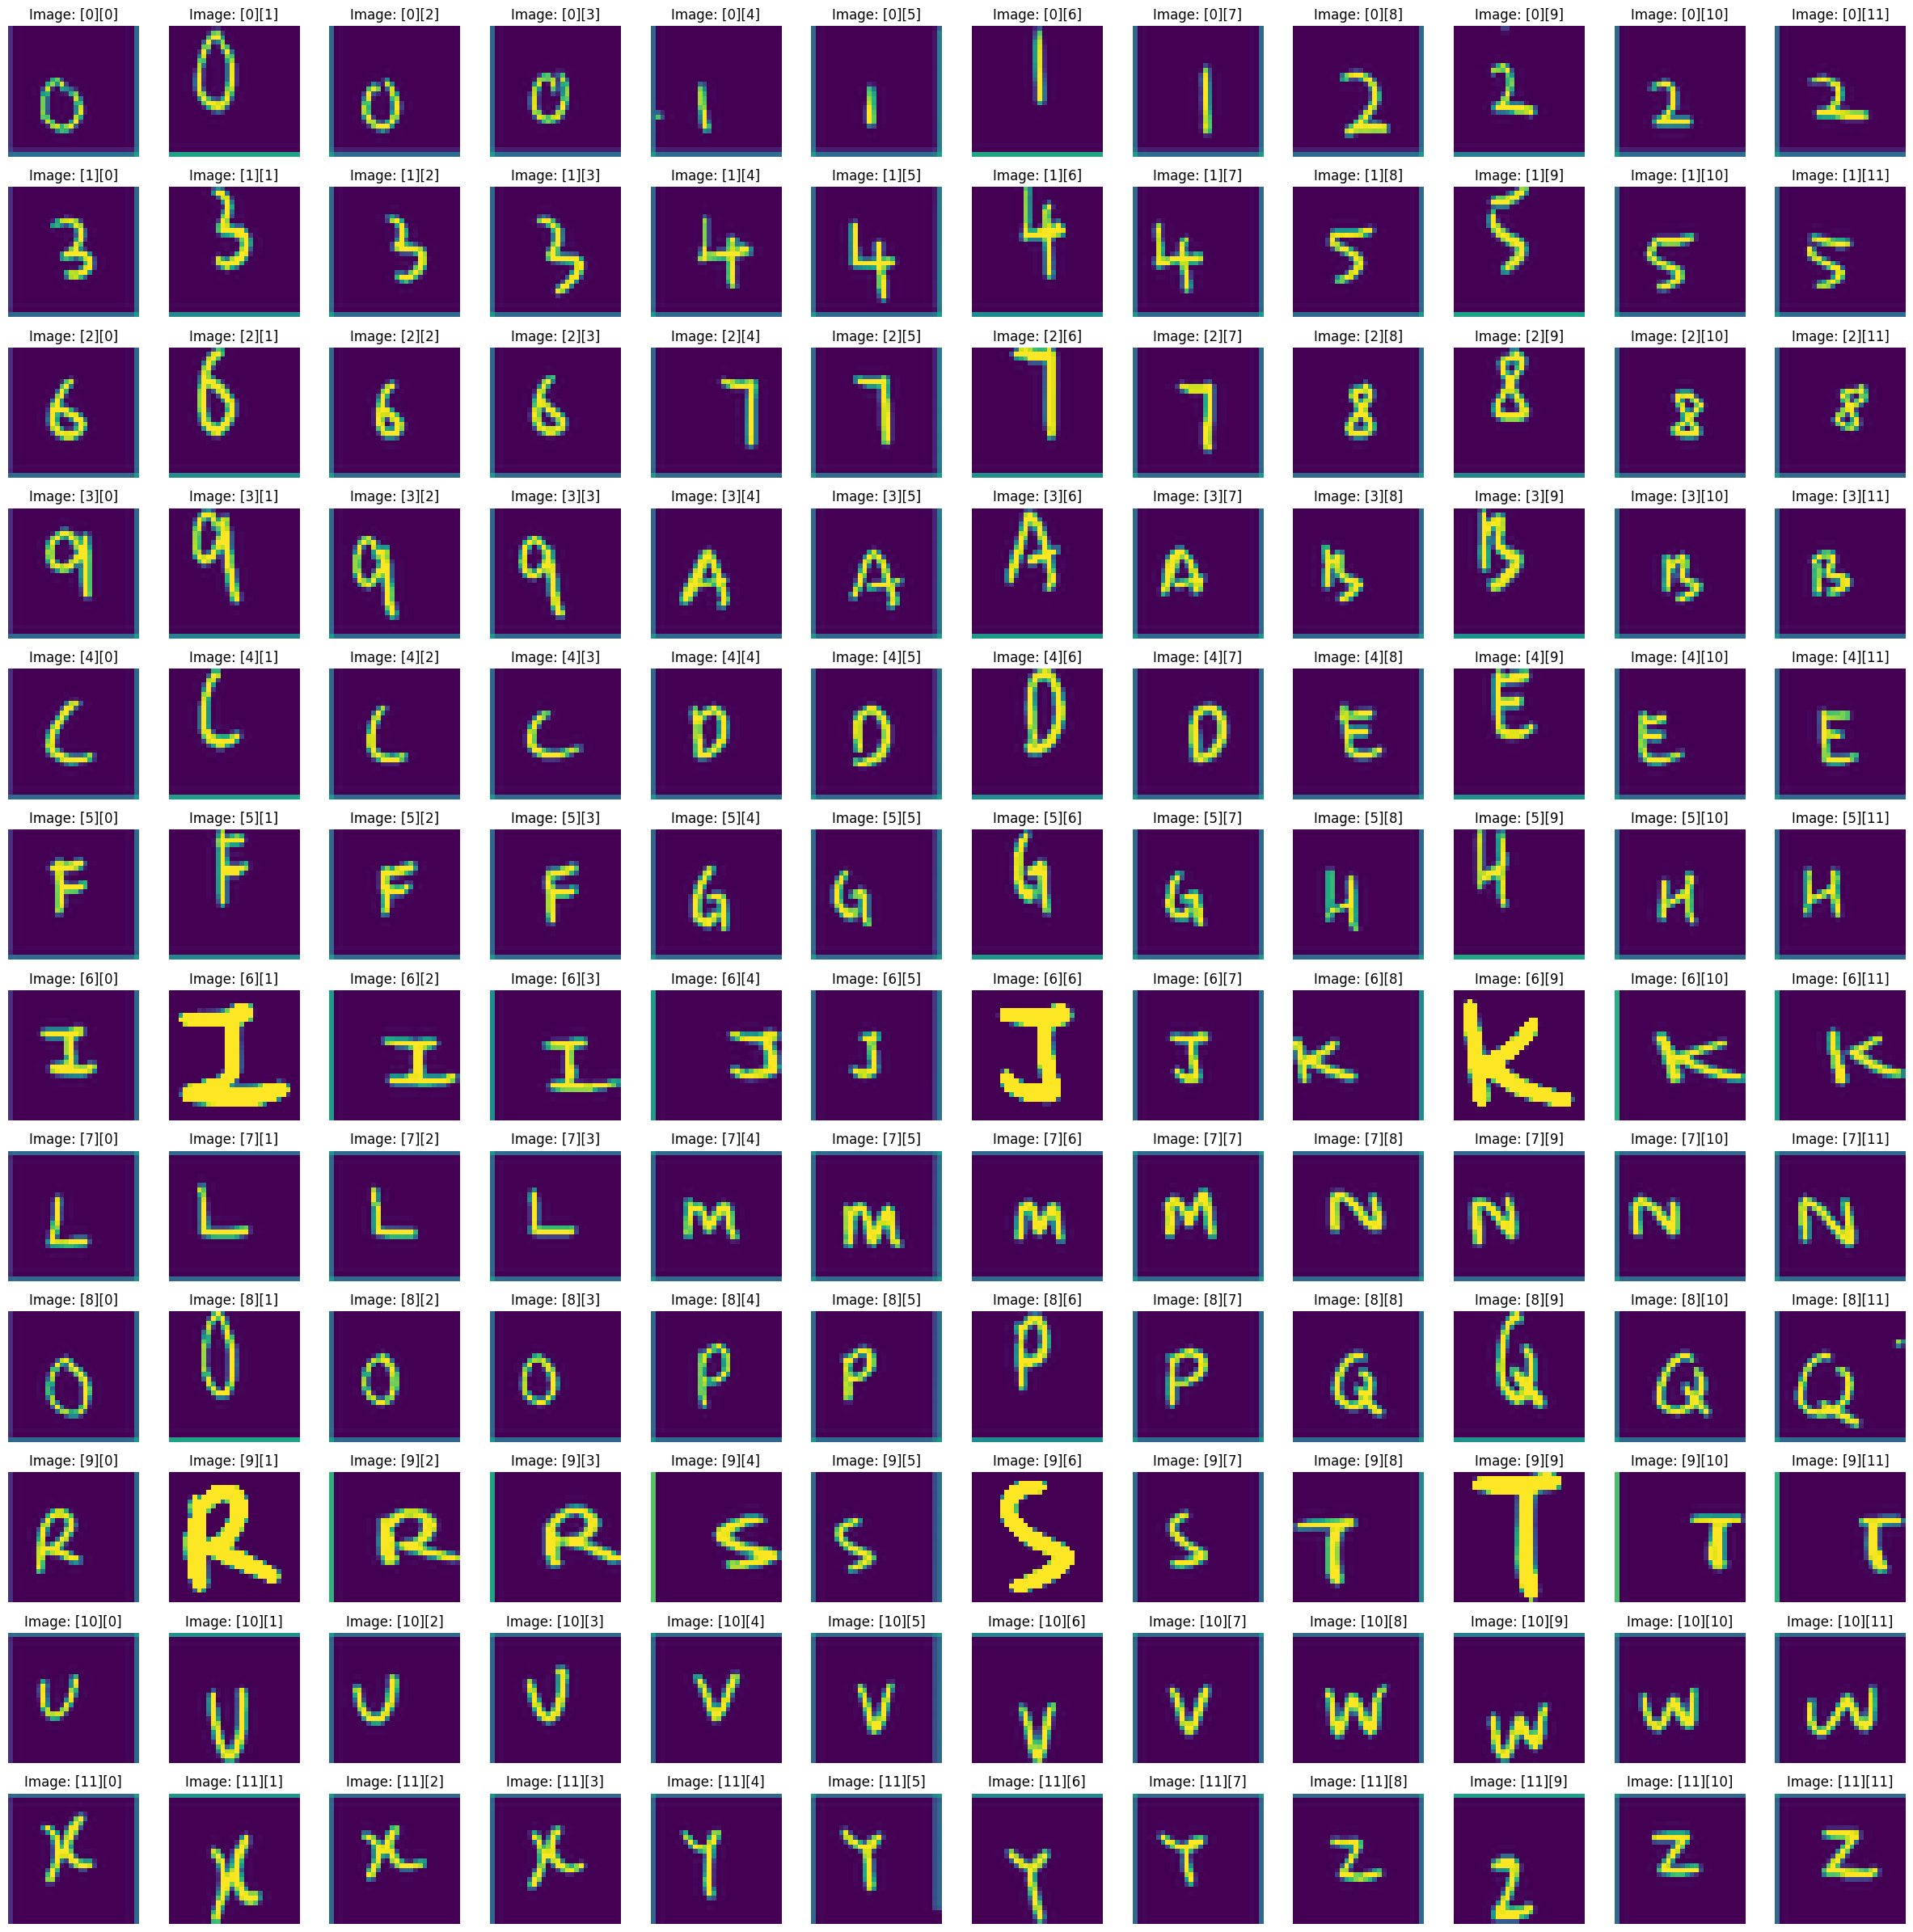

In [41]:
import matplotlib.pyplot as plt

# Determine the number of rows and the maximum number of columns needed
num_rows = len(resized_samples)
max_cols = max(len(sublist) for sublist in resized_samples)

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, max_cols, figsize=(max_cols*2, num_rows*2))  # Adjust figsize as needed

# If there's only one row, wrap axes in a list to simplify the loop logic below
if num_rows == 1:
    axes = [axes]

# Loop through each row and column to display images
for i, sublist in enumerate(resized_samples):
    for j, img in enumerate(sublist):
        if num_rows > 1:
            ax = axes[i][j]
        else:
            ax = axes[j]
        ax.imshow(img)  # Show image
        ax.set_title(f'Image: [{i}][{j}]')  # Optional: set title with indices
        ax.axis('off')  # Hide axis

# Hide any unused axes if the last row isn't full
if num_rows > 1:
    for idx in range(len(sublist), max_cols):
        axes[i][idx].axis('off')
else:
    for idx in range(len(sublist), max_cols):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [42]:
for row in resized_samples:
    for sample in row:
        if sample.size != (28, 28):
            print(f"Found an image of incorrect size: {sample.size}")

In [43]:
binary_samples = np.array([[sample.getdata() for sample in row] for row in resized_samples])
binary_samples = binary_samples.reshape(len(resized_samples)*len(resized_samples[0]), 28, 28)

In [44]:
print(binary_samples.dtype)

int64


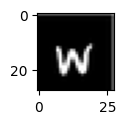

In [45]:
show(binary_samples[128], figsize=(1,1))

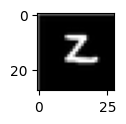

In [46]:
show(binary_samples[143], figsize=(1,1))

In [48]:
# Calculate the total number of samples
num_samples = len(resized_samples) * len(resized_samples[0])

# Create an array of labels
labels = np.array(['Shi Ting'] * num_samples)

In [49]:
print(f'X shape: {binary_samples.shape}')
print(f'y shape: {labels.shape}')

X shape: (144, 28, 28)
y shape: (144,)


In [50]:
xfile = 'digits_x_test.npy'
yfile = 'digits_y_test.npy'
np.save(xfile, binary_samples)
np.save(yfile, labels)

In [51]:
x_test = np.load(xfile)
y_test = np.load(yfile)
x_test.shape, y_test.shape

((144, 28, 28), (144,))

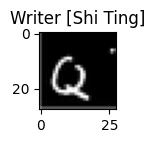

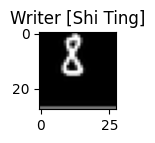

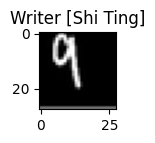

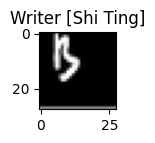

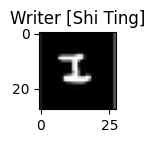

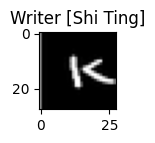

In [52]:
for i in np.random.randint(x_test.shape[0], size=6):
    show(x_test[i], title=f'Writer [{y_test[i]}]', figsize=(1,1))

In [53]:
x_test[0]

array([[ 34,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  86],
       [ 34,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  86],
       [ 34,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  86],
       [ 34,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  86],
       [ 34,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  86],
       [ 34,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  86],
       [ 3